# **Scanpy Analysis Pipeline for Single-Cell RNA-seq Data**

This script demonstrates a basic workflow using the Scanpy library:

1.   Loads three datasets (Control1, Control2, IAV) from 10x h5 files and concatenate.
2.   Performs QC and filtering.
3.   Run doublet detection using Scrublet.
4.   Normalize and log-transform the data.
5.   Define mouse-compatible cell cycle gene lists.
6.   Run Feature Selection & Dimensionality Reduction  
7.   Re-assess Final QC and Cell Filtering
8.   Save processed AnnData object

{Customize file paths, filtering thresholds, and parameters as needed.}

In [1]:
#conda activate scanpy
import scanpy as sc
import anndata as ad
import numpy as np
import skimage
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import warnings
warnings.filterwarnings('ignore')

#Set WD
os.chdir("/Users/alexanderfoote/dev/Projs/Python/scRNA_analysis_7dpi_IAV")

# Set a global random seed to make sure you can reproduce your exact cluster assignment later
np.random.seed(0)
sc.settings.seed = 0
# Set Scanpy verbosity and figure parameters
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=100, facecolor='white')

# **1. Load Datasets**


In [2]:
# 1) map each sample name to its 10x HDF5 file path
samples = {
    "Control1": "/Users/alexanderfoote/raw_data/Cell Ranger Matix Data Files/IAV_mouse-genome_cellranger_02142024_7dp-IAV/control_v1/Crtl1_filtered_feature_bc_matrix.h5",
    "Control2": "/Users/alexanderfoote/raw_data/Cell Ranger Matix Data Files/IAV_mouse-genome_cellranger_02142024_7dp-IAV/control_v2/Crtl2_filtered_feature_bc_matrix.h5",
    "IAV"     : "/Users/alexanderfoote/raw_data/Cell Ranger Matix Data Files/IAV_mouse-genome_cellranger_02142024_7dp-IAV/flu/IAV_filtered_feature_bc_matrix.h5",
}

# 2) read each sample into a dict of AnnData objects
adatas = {}
for sample_id, filepath in samples.items():
    adata_sample = sc.read_10x_h5(filepath)
    # ensure unique gene names to avoid downstream errors
    adata_sample.var_names_make_unique()
    adatas[sample_id] = adata_sample

# 3) concatenate them into one AnnData, automatically adding `adata.obs['sample']`
adata = ad.concat(adatas, label="sample")

# 4) make every cell‐barcode name unique (optional but recommended)
adata.obs_names_make_unique()

# 5) check you got what you expect
print(adata.obs["sample"].value_counts())
adata

reading /Users/alexanderfoote/raw_data/Cell Ranger Matix Data Files/IAV_mouse-genome_cellranger_02142024_7dp-IAV/control_v1/Crtl1_filtered_feature_bc_matrix.h5
 (0:00:00)
reading /Users/alexanderfoote/raw_data/Cell Ranger Matix Data Files/IAV_mouse-genome_cellranger_02142024_7dp-IAV/control_v2/Crtl2_filtered_feature_bc_matrix.h5
 (0:00:00)
reading /Users/alexanderfoote/raw_data/Cell Ranger Matix Data Files/IAV_mouse-genome_cellranger_02142024_7dp-IAV/flu/IAV_filtered_feature_bc_matrix.h5
 (0:00:00)
sample
IAV         7472
Control2    6865
Control1    3648
Name: count, dtype: int64


AnnData object with n_obs × n_vars = 17985 × 31054
    obs: 'sample'

## *Run Function for Metadata Printout*

In [3]:
def check_metadata_table(adata, condition_name):
    summary_list = []
    for col in adata.obs.columns:
        col_dtype = adata.obs[col].dtype
        unique_vals = adata.obs[col].nunique()
        missing_vals = adata.obs[col].isnull().sum()
        sample_vals = adata.obs[col].dropna().unique()[:5]  # First 5 unique non-null values
        summary_list.append({
            "Column": col,
            "Data Type": str(col_dtype),
            "Unique Count": unique_vals,
            "Missing Count": missing_vals,
            "Sample Values": ", ".join(map(str, sample_vals))
        })
    summary_df = pd.DataFrame(summary_list)
    print(f"\nMetadata Summary for {condition_name}:")
    return summary_df

# **2. Quality Control (QC)**

1.   Performs QC and filtering on an AnnData object:
  *   Ensures unique gene names.
  *   Computes total counts, n of genes, n of counts, and % mitochondrial.
  *   Visualizes QC metrics.
  *   Filters cells with low/high gene and UMI counts and high mitochondrial percentage.
  *   Filters genes expressed in fewer than min_cells.
-------------------------
2.   Function to Check Metadata
  *    Creates and prints a summary table of the metadata (adata.obs) using pandas.

  The table includes:
  - Column name
  - Data type
  - Number of unique values
  - Number of missing values
  - Up to 5 sample unique values



QC metrics BEFORE filtering:


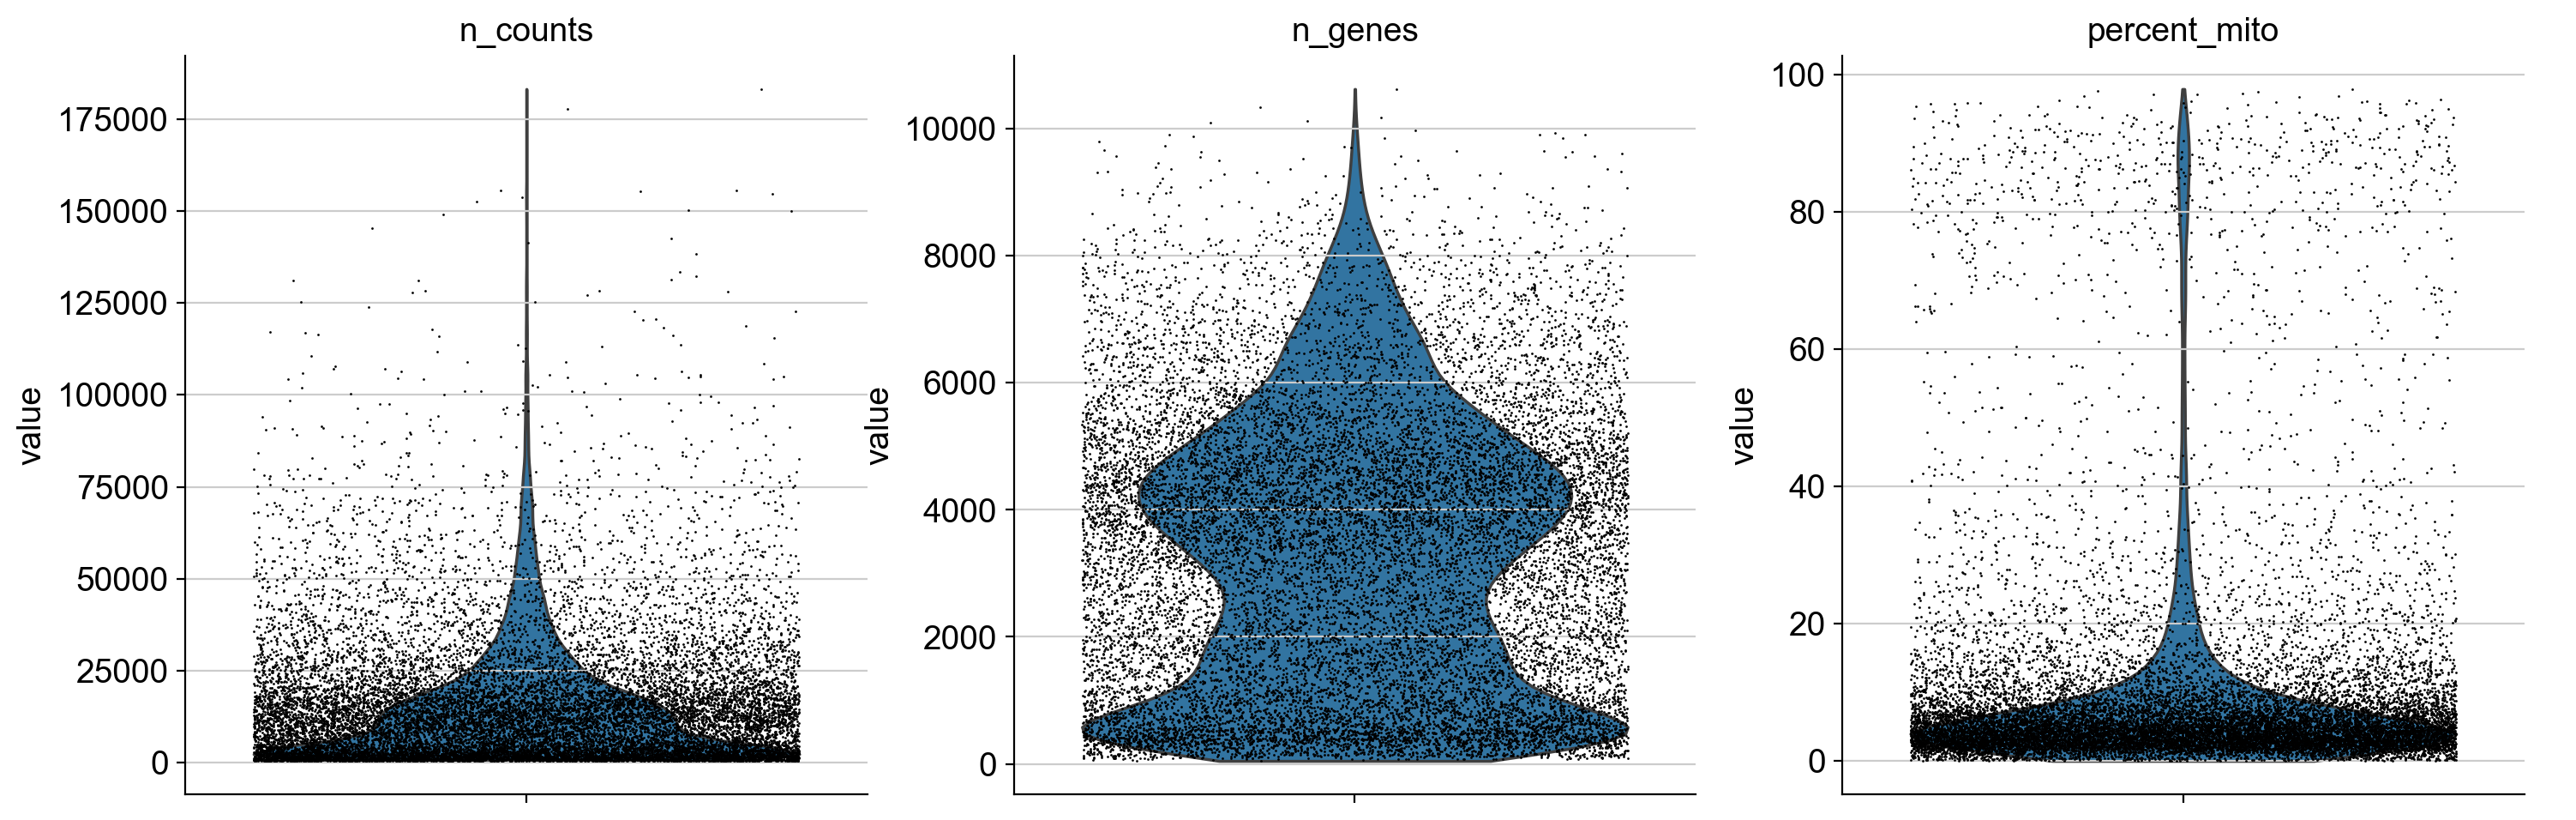


Metadata Summary for (QC/unfiltered):


,Column,Data Type,Unique Count,Missing Count,Sample Values
0,sample,category,3,0,"Control1, Control2, IAV"
1,n_counts,float32,13285,0,"7339.0, 5154.0, 4282.0, 19036.0, 1186.0"
2,n_genes,int64,6761,0,"2536, 2066, 1573, 5117, 244"
3,percent_mito,float32,17823,0,"2.057501, 3.8222742, 7.77674, 4.853961, 12.478921"


filtered out 407 cells that have less than 200 genes expressed
filtered out 7574 genes that are detected in less than 3 cells
QC metrics AFTER filtering:


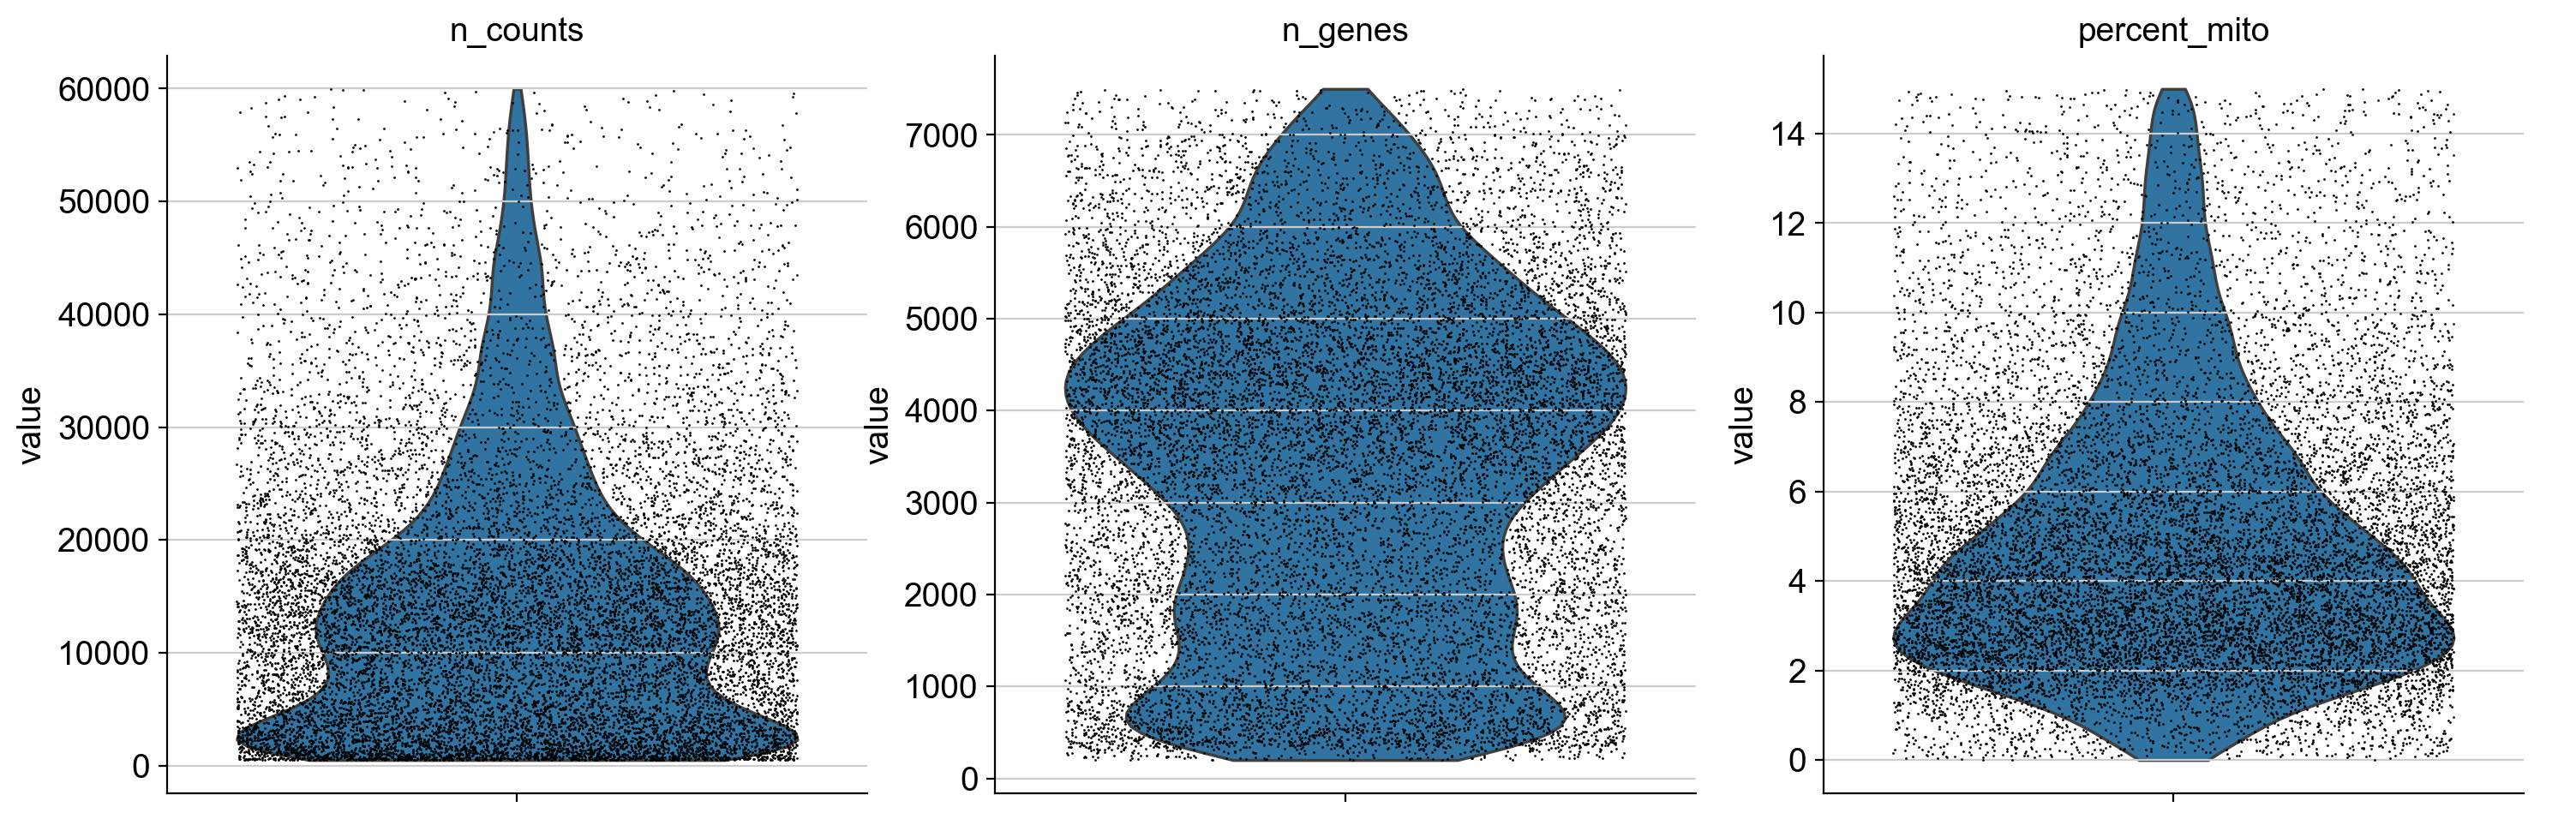


Metadata Summary for (QC/filtered):


,Column,Data Type,Unique Count,Missing Count,Sample Values
0,sample,category,3,0,"Control1, Control2, IAV"
1,n_counts,float32,11710,0,"7339.0, 5154.0, 4282.0, 19036.0, 1186.0"
2,n_genes,int64,5982,0,"2536, 2066, 1573, 5117, 244"
3,percent_mito,float32,14559,0,"2.057501, 3.8222742, 7.77674, 4.853961, 12.478921"


Filtered Data Visualized as Scatterplot:


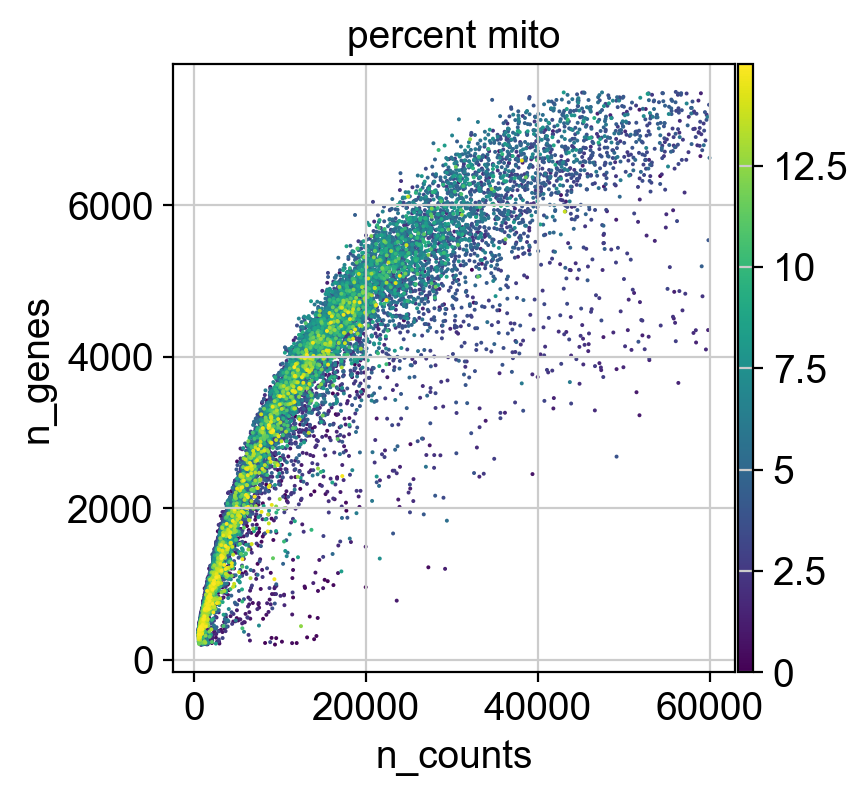

In [4]:
def qc_and_filter(adata, mito_prefix='mt-', min_genes=200, max_genes=7500, mito_threshold=15, min_cells=3):

    # Calculate QC metrics
    adata.obs['n_counts'] = adata.X.sum(axis=1).A1 if hasattr(adata.X, "A1") else adata.X.sum(axis=1)
    adata.obs['n_genes'] = (adata.X > 0).sum(axis=1)
    mito_genes = adata.var_names.str.startswith(mito_prefix)
    # Calculate percent mitochondrial reads
    adata.obs['percent_mito'] = (adata.X[:, mito_genes].sum(axis=1).A1 / adata.obs['n_counts']) * 100
    # Visualize QC metrics
    print("QC metrics BEFORE filtering:")
    sc.pl.violin(adata, ['n_counts', 'n_genes', 'percent_mito'], jitter=0.4, multi_panel=True, show=False)       
    plt.show()
    # Show metadata BEFORE any QC
    display(check_metadata_table(adata, "(QC/unfiltered)"))
    # Filter cells: minimum/maximum genes expressed and maximum mitochondrial percentage
    sc.pp.filter_cells(adata, min_genes=min_genes)
    adata = adata[adata.obs['n_genes'] <= max_genes, :]
    adata = adata[adata.obs['percent_mito'] < mito_threshold, :]
     # Filter cells based on total UMI counts (n_counts)
    adata = adata[adata.obs['n_counts'] >= 200, :]
    adata = adata[adata.obs['n_counts'] <= 60000, :]
    # Filter genes: keep genes expressed in at least 'min_cells' cells
    sc.pp.filter_genes(adata, min_cells=min_cells)
    # Visualize QC metrics
    print("QC metrics AFTER filtering:")
    sc.pl.violin(adata, ['n_counts', 'n_genes', 'percent_mito'], jitter=0.4, multi_panel=True, show=False,)
    plt.show()
    # Show metadata AFTER QC
    display(check_metadata_table(adata, "(QC/filtered)"))

    return adata

# Apply QC and filtering function
adata = qc_and_filter(adata)

print("Filtered Data Visualized as Scatterplot:")
sc.pl.scatter(adata, "n_counts", "n_genes", color="percent_mito")


# **3. Doublet Detection using Scrublet**
Runs doublet detection using Scrublet and adds doublet scores and predictions to adata.obs.

In [5]:
def detect_doublets(adata, batch_key="sample"):
    sc.external.pp.scrublet(adata, batch_key=batch_key)
    return adata

# Apply doublet detection on each dataset
adata = detect_doublets(adata, batch_key="sample")

# Check metadata after doublet detection
check_metadata_table(adata, "(after doublet detection)")

Running Scrublet
filtered out 3776 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    using data matrix X directly
Automatically set threshold at doublet score = 0.47
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 2.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.7%
filtered out 1632 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.

,Column,Data Type,Unique Count,Missing Count,Sample Values
0,sample,object,3,0,"Control1, Control2, IAV"
1,n_counts,float32,11710,0,"7339.0, 5154.0, 4282.0, 19036.0, 1186.0"
2,n_genes,int64,5974,0,"2536, 2066, 1573, 5117, 244"
3,percent_mito,float32,14559,0,"2.057501, 3.8222742, 7.77674, 4.853961, 12.478921"
4,doublet_score,float64,249,0,"0.03483309143686503, 0.019758507135016472, 0.0..."
5,predicted_doublet,bool,2,0,"False, True"


# **4. Normalize and Log-Transform**


In [6]:
def normalize_data(adata, target_sum=1e4):
    # Preserve the original counts in a layer
    adata.layers["counts"] = adata.X.copy()
    
    # Freeze the *un-normalized* data in .raw
    #    (so raw.X is still the original counts)
    adata.raw = adata.copy()
    
    # Now normalize and log-transform in place
    sc.pp.normalize_total(adata, target_sum=target_sum)  # scales to target_sum
    sc.pp.log1p(adata)                                   # log(1 + counts)
    
    return adata

# Apply to each dataset
adata = normalize_data(adata)

# Quick sanity checks
print(adata)
print("RAW shape:", adata.raw.X.shape, "  LAYERS keys:", adata.layers.keys())

check_metadata_table(adata, "(normalized)")

normalizing counts per cell
    finished (0:00:00)
AnnData object with n_obs × n_vars = 14693 × 23480
    obs: 'sample', 'n_counts', 'n_genes', 'percent_mito', 'doublet_score', 'predicted_doublet'
    var: 'n_cells'
    uns: 'scrublet', 'log1p'
    layers: 'counts'
RAW shape: (14693, 23480)   LAYERS keys: KeysView(Layers with keys: counts)

Metadata Summary for (normalized):


,Column,Data Type,Unique Count,Missing Count,Sample Values
0,sample,object,3,0,"Control1, Control2, IAV"
1,n_counts,float32,11710,0,"7339.0, 5154.0, 4282.0, 19036.0, 1186.0"
2,n_genes,int64,5974,0,"2536, 2066, 1573, 5117, 244"
3,percent_mito,float32,14559,0,"2.057501, 3.8222742, 7.77674, 4.853961, 12.478921"
4,doublet_score,float64,249,0,"0.03483309143686503, 0.019758507135016472, 0.0..."
5,predicted_doublet,bool,2,0,"False, True"


# **5. Define Cell Cycle Assignment**

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    472 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    600 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


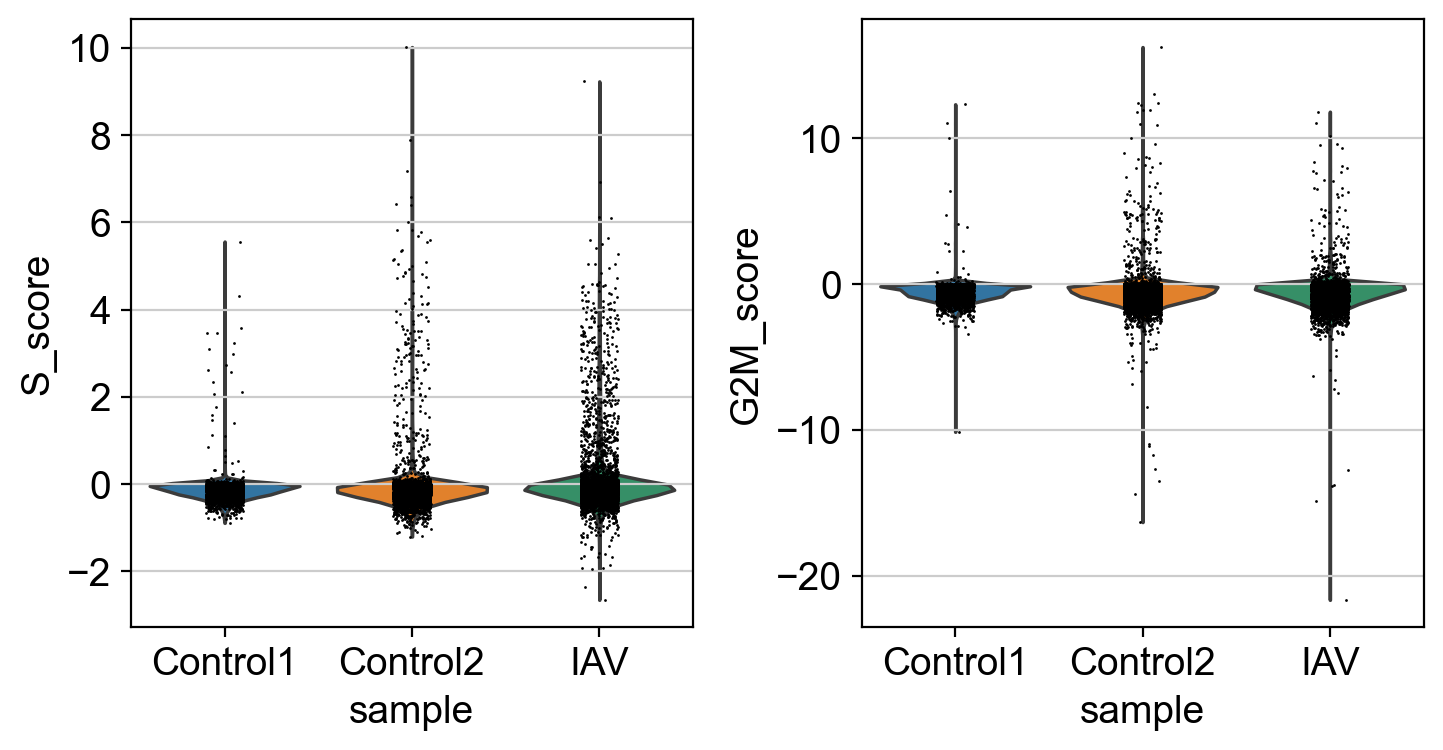


Metadata Summary for (after cell cycle scoring):


,Column,Data Type,Unique Count,Missing Count,Sample Values
0,sample,category,3,0,"Control1, Control2, IAV"
1,n_counts,float32,11710,0,"7339.0, 5154.0, 4282.0, 19036.0, 1186.0"
2,n_genes,int64,5974,0,"2536, 2066, 1573, 5117, 244"
3,percent_mito,float32,14559,0,"2.057501, 3.8222742, 7.77674, 4.853961, 12.478921"
4,doublet_score,float64,249,0,"0.03483309143686503, 0.019758507135016472, 0.0..."
5,predicted_doublet,bool,2,0,"False, True"
6,S_score,float64,5739,0,"-0.14517756255044392, -0.12076271186440678, -0..."
7,G2M_score,float64,9941,0,"-0.26032520325203257, -0.3184959349593496, -0...."
8,phase,category,3,0,"G1, S, G2M"


In [7]:
# Define cell cycle gene lists (commonly used markers from Tirosh et al.)
s_genes_mouse = [
 "Mcm5", "Pcna", "Tyms", "Fen1", "Mcm2", "Mcm4", "Rrm1", "Ung", 
"Gins2", "Mcm6", "Cdca7", "Dtl", "Prim1", "Uhrf1", "Mlf1ip", "Hells", 
"Rfc2", "Rpa2", "Nasp", "Rad51ap1", "Gmnn", "Wdr76", "Slbp", "Ccne2", 
"Ubr7", "Pold3", "Msh2", "Atad2", "Rad51", "Rrm2", "Cdc45", "Cdc6", 
"Exo1", "Tipin", "Dscc1", "Blm", "Casp8ap2", "Usp1", "Clspn", "Pola1", 
"Chaf1b", "Brip1", "E2f8"
]
g2m_genes_mouse = [
"Mki67", "Tmpo", "Cenpf", "Tacc3", "Fam64a", "Smc4", "Ccnb2", "Ckap2l", "Ckap2", 
"Aurkb", "Bub1", "Kif11", "Anp32e", "Tubb4b", "Gtse1", "Kif20b", "Hjurp", "Cdca3", 
"Hn1", "Cdc20", "Ttk", "Cdc25c", "Kif2c", "Rangap1", "Ncapd2", "Dlgap5", "Cdca2", 
"Cdca8", "Ect2", "Kif23", "Hmmr", "Aurka", "Psrc1", "Anln", "Lbr", "Ckap5", "Cenpe", 
"Ctcf", "Nek2", "G2e3", "Gas2l3", "Cbx5", "Cenpa"
]

def score_cell_cycle(adata, condition):
    # Cell cycle scoring
    sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes_mouse, g2m_genes=g2m_genes_mouse)
    sc.pl.violin(adata, ['S_score', 'G2M_score'], groupby='sample', show=True)
    return adata

# Run cell cycle scoring function
adata = score_cell_cycle(adata, "adata")
check_metadata_table(adata, "(after cell cycle scoring)")

# **6. Run Feature Selection & Dimensionality Reduction**

*   Highly Variable Genes Selection (i.e. Feature Selection)
*   Dimensionality Reduction (i.e. Scaling, PCA, Neighbors, UMAP)

In [8]:
def feature_selection(adata, condition):
    # Highly Variable Genes Selection
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=4000, flavor = 'seurat_v3')
    print(f"Number of HVGs ({condition}):", adata.var['highly_variable'].sum())
    adata = adata[:, adata.var.highly_variable]
    return adata

# Run feature selection function
adata = feature_selection(adata, "adata")
check_metadata_table(adata, "(after cell cycle scoring)")

extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
Number of HVGs (adata): 4000

Metadata Summary for (after cell cycle scoring):


,Column,Data Type,Unique Count,Missing Count,Sample Values
0,sample,category,3,0,"Control1, Control2, IAV"
1,n_counts,float32,11710,0,"7339.0, 5154.0, 4282.0, 19036.0, 1186.0"
2,n_genes,int64,5974,0,"2536, 2066, 1573, 5117, 244"
3,percent_mito,float32,14559,0,"2.057501, 3.8222742, 7.77674, 4.853961, 12.478921"
4,doublet_score,float64,249,0,"0.03483309143686503, 0.019758507135016472, 0.0..."
5,predicted_doublet,bool,2,0,"False, True"
6,S_score,float64,5739,0,"-0.14517756255044392, -0.12076271186440678, -0..."
7,G2M_score,float64,9941,0,"-0.26032520325203257, -0.3184959349593496, -0...."
8,phase,category,3,0,"G1, S, G2M"


regressing out ['n_counts', 'percent_mito', 'S_score', 'G2M_score']
    sparse input is densified and may lead to high memory use
    finished (0:00:00)
computing PCA
    with n_comps=50
    finished (0:00:01)


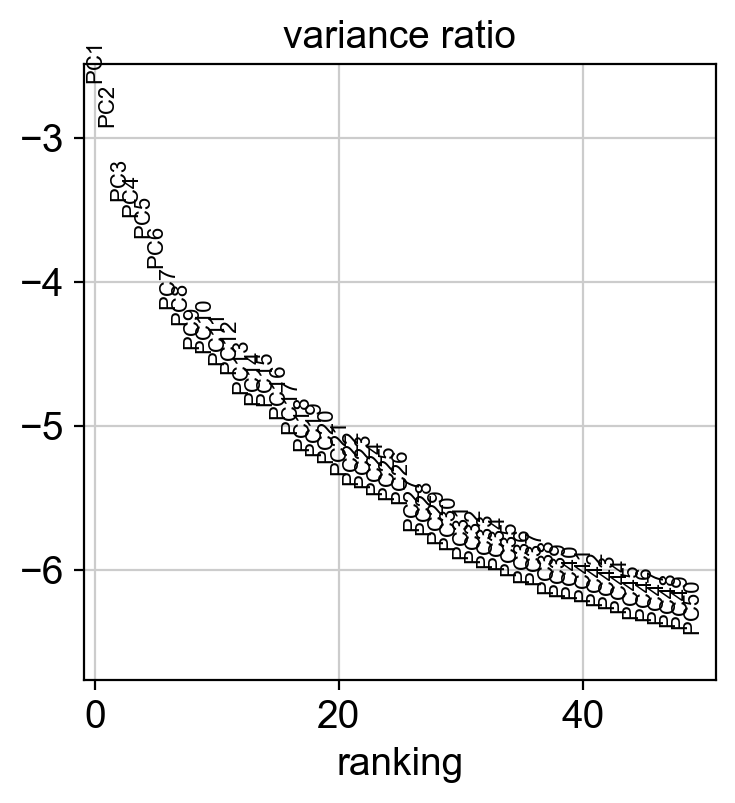

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
running Leiden clustering
    finished: found 44 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:04)


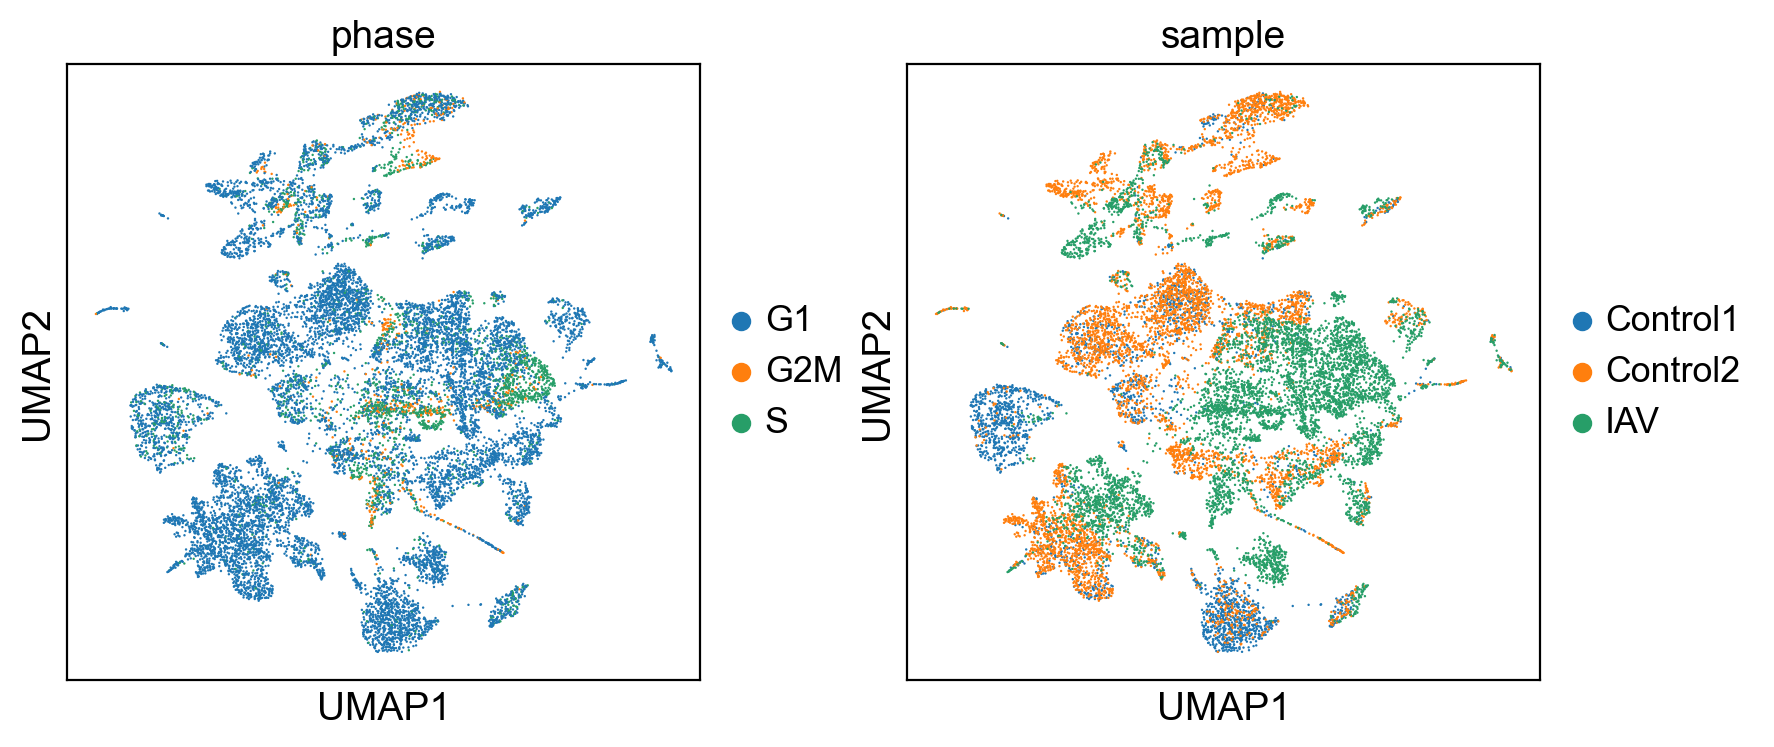

In [9]:
def dimensionality_reduction(adata, condition):
    # Variables to regress out
    sc.pp.regress_out(adata, keys=['n_counts', 'percent_mito', 'S_score', 'G2M_score'])
    # Dimentionality reduction with PCA
    sc.pp.scale(adata, max_value=10) # z normalize the columns (genes)
    sc.tl.pca(adata, svd_solver='arpack')
    sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)
    # Compute Nearest Neighbors and UMAP
    sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40) # compute nearest neighbors
    sc.tl.leiden(adata, flavor="igraph", n_iterations=2, random_state=0) # default resolution=1.0
    sc.tl.umap(adata, random_state=0)
    sc.pl.umap(adata, color=['phase', 'sample'], size=3, show=True)
    return adata

# Run feature selection function
adata = dimensionality_reduction(adata, "adata")

If you inspect batch effects in your UMAP it can be beneficial to integrate across samples and perform batch correction/integration at this point. One can check out scanorama and scvi-tools for batch integration. Scvanpy uses BBKNN.

# **7. Re-assess Final QC and Cell Filtering**

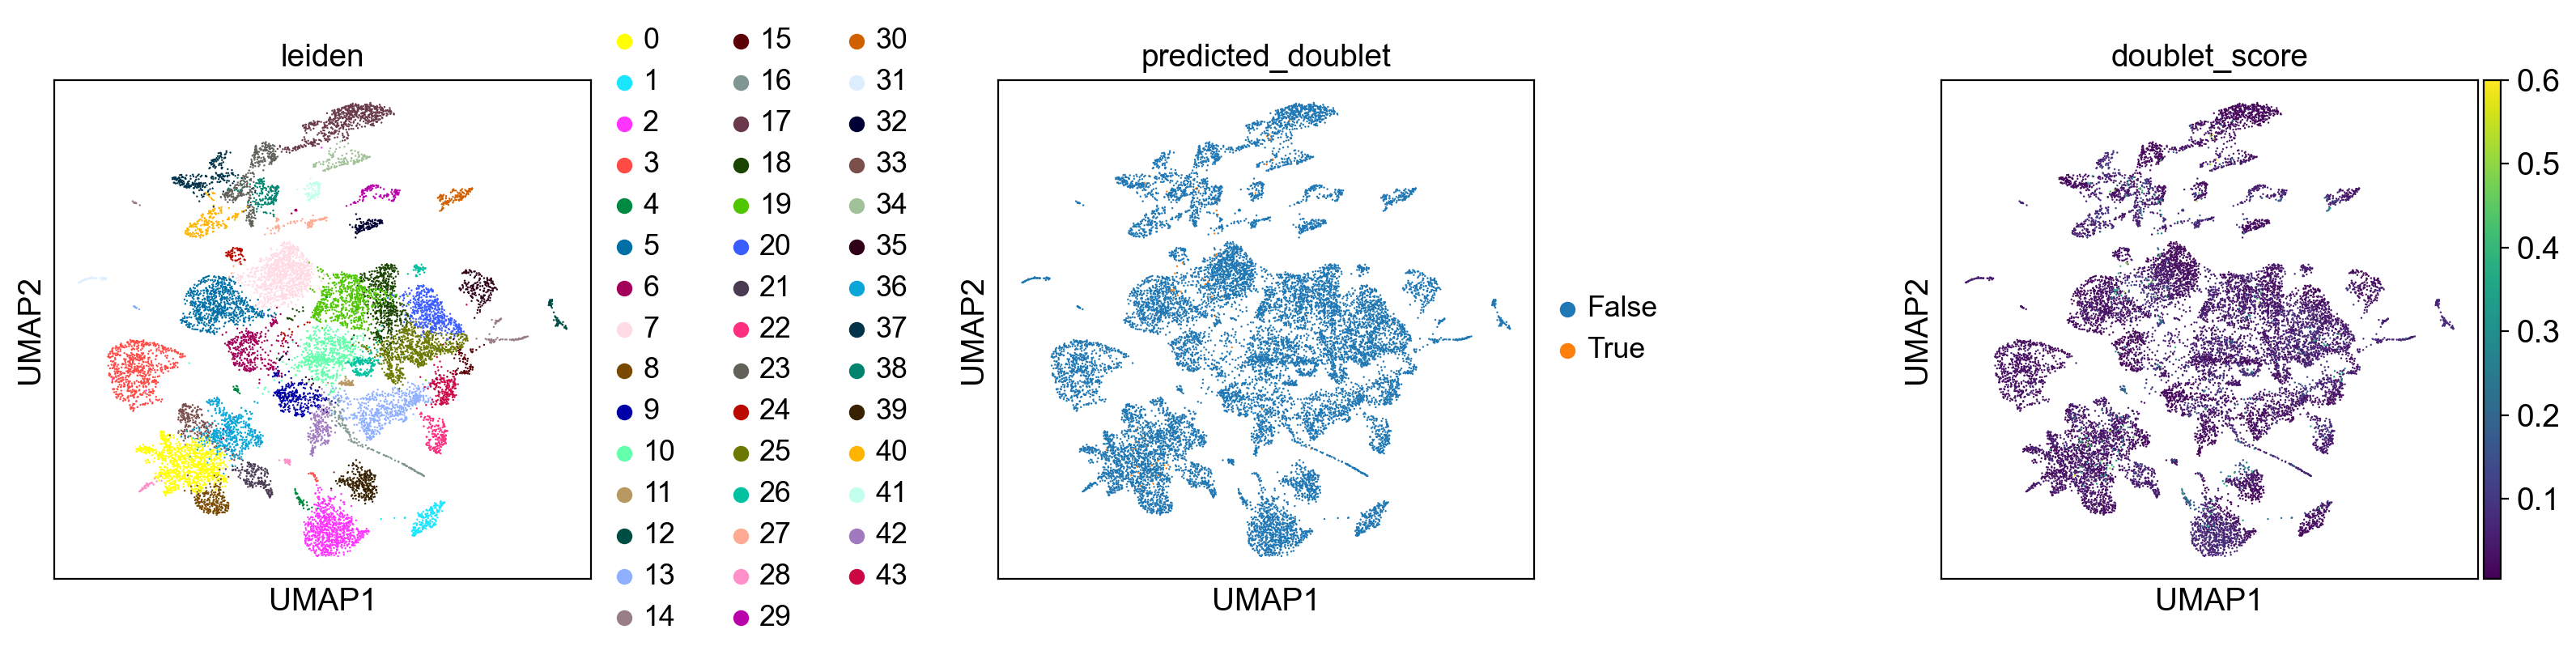


Metadata Summary for (final QC):


,Column,Data Type,Unique Count,Missing Count,Sample Values
0,sample,category,3,0,"Control1, Control2, IAV"
1,n_counts,float32,11710,0,"7339.0, 5154.0, 4282.0, 19036.0, 1186.0"
2,n_genes,int64,5974,0,"2536, 2066, 1573, 5117, 244"
3,percent_mito,float32,14559,0,"2.057501, 3.8222742, 7.77674, 4.853961, 12.478921"
4,doublet_score,float64,249,0,"0.03483309143686503, 0.019758507135016472, 0.0..."
5,predicted_doublet,bool,2,0,"False, True"
6,S_score,float64,5739,0,"-0.14517756255044392, -0.12076271186440678, -0..."
7,G2M_score,float64,9941,0,"-0.26032520325203257, -0.3184959349593496, -0...."
8,phase,category,3,0,"G1, S, G2M"
9,leiden,category,44,0,"0, 1, 3, 4, 2"


In [10]:
# For Saline: re-check metadata and plot final QC metrics
sc.pl.umap(adata, color=["leiden", "predicted_doublet", "doublet_score"],
    wspace=0.6, # increase horizontal space between panels  
    size=3
)

check_metadata_table(adata, "(final QC)")

# **8. Save Non-Integrated Object**


In [11]:
os.chdir("/Users/alexanderfoote/dev/Projs/Python/scRNA_analysis_7dpi_IAV/h5ad")
print("Writing to:", os.getcwd())
adata.write("non-integrated_processed.h5ad")

Writing to: /Users/alexanderfoote/dev/Projs/Python/scRNA_analysis_7dpi_IAV/h5ad
